# Fig2A

In [2]:
import umap
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Circle
from lifelines import KaplanMeierFitter

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/matsuuratakeru/anaconda3/envs/newbase/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir('./T-Matsuura_LDLT')
path = os.getcwd()

In [ ]:
train_X_180 = pd.read_csv(path+'/Data/train_X_180_revise.csv',index_col=0)
train_y_180 = pd.read_csv(path+'/Data/train_y_180_revise.csv',index_col=0)
val_X_180 = pd.read_csv(path+'/Data/val_X_180_revise.csv',index_col=0)
val_Y_180 = pd.read_csv(path+'/Data/val_Y_180_revise.csv',index_col=0)

In [5]:
#Unnecessary factor exclusion
X_180 = train_X_180.drop(['Rp_neutro','Rp_lymph','Portal_vein_blood_flow','SLV','Rp_HBsAb_No','graft2_Right lobe and above','graft2_Posterior area','BD stenosis_Yes','Rp_preportal_vein_thrombosis_complete','Rp_preportal_vein_thrombosis_partial','Rp_preportal_vein_thrombosis_No','ALF_Yes','BD stenosis_No','Bile leak_No','Simulect_No','introductory_MMF_No','Biliary stent_No','Bypass_No','shunt_0','Rp_preoperative_esophageal_varices_(post-EIS_also_referred_to_as_EIS)_No','Liver_resection_transplant_history_No','History_of _pper_abdominal_laparotomy_No','Rp_splenectomy1_0','preCKD_No','Rp_preascite_0','preDM_No','portal_vein_thrombosis2_No','graft2_Left lobe','donor_sex_F','bloodrelation_No','HCVAB_No','donor_HTLV1_No','HTLV1_No','donor_HBcAb_No','Rp_sex_F','HCC_No','ALF_No'],axis = 1).reset_index(drop=True)#相関の高い因子の除去
X_180_val = val_X_180.drop(['Rp_neutro','Rp_lymph','Portal_vein_blood_flow','SLV','Rp_HBsAb_No','graft2_Right lobe and above','graft2_Posterior area','BD stenosis_Yes','Rp_preportal_vein_thrombosis_complete','Rp_preportal_vein_thrombosis_partial','Rp_preportal_vein_thrombosis_No','ALF_Yes','BD stenosis_No','Bile leak_No','Simulect_No','introductory_MMF_No','Biliary stent_No','Bypass_No','shunt_0','Rp_preoperative_esophageal_varices_(post-EIS_also_referred_to_as_EIS)_No','Liver_resection_transplant_history_No','History_of _pper_abdominal_laparotomy_No','Rp_splenectomy1_0','preCKD_No','Rp_preascite_0','preDM_No','portal_vein_thrombosis2_No','graft2_Left lobe','donor_sex_F','bloodrelation_No','HCVAB_No','donor_HTLV1_No','HTLV1_No','donor_HBcAb_No','Rp_sex_F','HCC_No','ALF_No'],axis = 1).reset_index(drop=True)#相関の高い因子の除去
y = train_y_180['graftloss_within_6months'].astype('bool').reset_index(drop=True)
val_y = val_Y_180['graftloss_within_6months'].astype('bool').reset_index(drop=True)

In [6]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 4,class_weight='balanced',max_depth = None, min_samples_split =  2, n_estimators = 500)
rfc.fit(X_180,y)
leaves = rfc.apply(X_180)
from sklearn.preprocessing import OneHotEncoder
M = OneHotEncoder().fit_transform(leaves)
S = (M*M.transpose()).todense()
D = 1 - S/S.max()
D = np.asarray(D)



In [7]:
#Clustering definition 
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

In [8]:
import scipy
from scipy.sparse import csgraph
# from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    # eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues,s=2)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/matsuuratakeru/anaconda3/envs/newbase/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Optimal number of clusters [ 95 107 112  22 116]


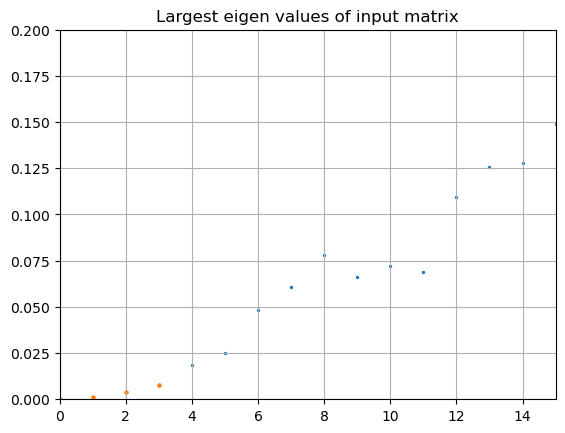

In [9]:
#decide number of clusters
embed_umap2 = umap.UMAP(random_state = 12).fit_transform(D)
affinity_matrix = getAffinityMatrix(embed_umap2, k = 13);
k, l,  _ = eigenDecomposition(affinity_matrix);
print(f'Optimal number of clusters {k}')
plt.xlim(0,15)
plt.ylim(0,0.2)
plt.scatter(np.arange(4),l[0:4], s=5) 





In [10]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=1234).fit(embed_umap2)
clustering.labels_

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


array([0, 4, 2, 4, 0, 2, 4, 4, 2, 4, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 1,
       0, 2, 1, 4, 0, 3, 0, 4, 0, 1, 2, 4, 2, 0, 3, 4, 0, 4, 4, 1, 2, 2,
       4, 2, 0, 2, 3, 0, 4, 4, 0, 0, 1, 2, 2, 2, 1, 1, 2, 2, 0, 0, 0, 0,
       0, 2, 4, 2, 4, 2, 0, 2, 1, 1, 4, 4, 0, 4, 1, 4, 2, 4, 4, 0, 3, 4,
       3, 0, 0, 1, 0, 2, 4, 1, 2, 4, 1, 0, 0, 4, 0, 0, 1, 2, 4, 2, 3, 4,
       4, 1, 0, 1, 0, 1, 0, 3, 1, 0, 4, 0, 0, 4, 1, 4, 4, 0, 1, 1, 0, 0,
       2, 1, 4, 4, 4, 1, 0, 0, 2, 0, 3, 2, 1, 2, 0, 1, 0, 4, 4, 0, 2, 0,
       4, 4, 3, 0, 2, 4, 0, 2, 4, 4, 0, 0, 4, 4, 3, 4, 1, 0, 2, 0, 0, 0,
       0, 0, 0, 4, 4, 4, 0, 3, 2, 2, 0, 4, 0, 1, 1, 1, 2, 2, 1, 1, 1, 4,
       4, 0, 1, 4, 0, 0, 0, 4, 4, 1, 0, 4, 0, 2, 4, 0, 0, 4, 1, 1, 1, 4,
       0, 0, 4, 0, 2, 0, 0, 2, 4, 2, 2, 0, 0, 4, 0, 0, 0, 0, 2, 0, 1, 2,
       4, 0, 0, 2, 2, 4, 0, 2, 0, 4, 2, 0, 0, 2, 2, 0, 0, 4, 4, 4, 4, 3,
       2, 2, 4, 1, 0, 4, 3, 2, 2, 2, 1, 0, 2, 2, 4, 2, 0, 0, 0, 0, 4, 1,
       4, 1, 1, 0, 4, 1, 0, 4, 2, 0, 0, 0, 0, 4, 4,

In [ ]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(figsize=(12,12))
ax.set_facecolor('white')

ccll=[]
for i in sorted(set(y)):
    index = y[y==i].index
    emb = embed_umap2[index,:]
    clusterLabel = clustering.labels_[index]
    
    if i == 1:
        plt.scatter(emb[:,0],emb[:,1],linewidths = 1, color = [cmap(k) for k in clusterLabel],s=100)
    if i == 0:
        plt.scatter(emb[:,0],emb[:,1],linewidths = 1.0,facecolors='none', color = [cmap(k) for k in clusterLabel],s=100)

circle1 = Line2D([0], [0], marker='o', color='black', label='Early graft loss', markersize=20,linestyle='None')
circle2 = Line2D([0], [0], marker='o',color='black', label='Long-term/No graft loss', markersize=20,linestyle='None', fillstyle='none')

plt.legend(handles=[circle1,circle2], loc='upper right',facecolor='white',prop={ "weight":"normal",'size':24},frameon=False)
plt.xlabel('UMAP 2',weight='normal',size = 40)
plt.ylabel('UMAP 1',weight='normal',size = 40)
plt.xticks(fontsize=32,weight='normal')
plt.yticks(fontsize=32,weight='normal')
ax.spines['top'].set_color('white')  # X軸
ax.spines['right'].set_color('white')
plt.text(4.5, 6.5, 'G3', ha='center', va='center', color='red', fontsize=32)
plt.text(4.5,2, 'G2', ha='center', va='center', color='purple', fontsize=32)
plt.text(-2, 5, 'G5', ha='center', va='center', color='blue', fontsize=32)
plt.text(0,3, 'G4', ha='center', va='center', color='green', fontsize=32)
plt.text(8,2, 'G1', ha='center', va='center', color='orange', fontsize=32)
plt.rcParams['font.family'] = 'Arial'
plt.savefig(path+'/Output/Fig2/Fig2A_revise.pdf', bbox_inches="tight")

# Fig2B

In [16]:
#Define each variable
y_copy = train_y_180.copy()
y_copy['ClustLabel'] = clustering.labels_
a = y_copy['graft_days_aive']
b = y_copy['graftloss']
c = y_copy['ClustLabel']

In [ ]:
# クラスターごとの生存時間分析

fig, ax = plt.subplots(figsize=(12,12))
ax.set_facecolor('white')

kmf_1 = KaplanMeierFitter()
kmf_2 = KaplanMeierFitter()
kmf_3 = KaplanMeierFitter()
kmf_4 = KaplanMeierFitter()
kmf_5 = KaplanMeierFitter()


#Cluster and label
kmf_1.fit(a[c==0],b[c==0],label = 'G5')
kmf_2.fit(a[c==1],b[c==1],label = 'G1')
kmf_3.fit(a[c==2],b[c==2],label = 'G4')
kmf_4.fit(a[c==3],b[c==3],label = 'G3')
kmf_5.fit(a[c==4],b[c==4],label = 'G2')




#Display of censored lines
kmf_1.plot_survival_function(show_censors = True)
kmf_2.plot_survival_function(show_censors = True)
kmf_3.plot_survival_function(show_censors = True)
kmf_4.plot_survival_function(show_censors = True)
kmf_5.plot_survival_function(show_censors = True)



plt.yticks([0.0,0.25,0.5,0.75,1.0],fontsize=32,weight='normal')
plt.xticks(fontsize=32,weight='normal')
handles, labels = plt.gca().get_legend_handles_labels()
new_order = [1,4,3,2,0]  #Aligning the Legends
handles = [handles[i] for i in new_order]
labels = [labels[i] for i in new_order]
plt.legend(handles,labels, bbox_to_anchor=(0.55, 0.8),prop={ "weight":"normal",'size':24},facecolor='white',frameon=False,ncol=2)

plt.xlabel('Postoperative days',weight='normal',size = 40)
plt.ylabel('Survival Probability',weight='normal',size = 40)
ax.spines['top'].set_color('white')  # X軸
ax.spines['right'].set_color('white')
plt.rcParams['font.family'] = 'Arial'
plt.savefig(path+'/Output/Fig2/Fig2B_revise.png',bbox_inches='tight')
plt.show()

In [ ]:
y_copy['ClustLabel'].to_csv(path+'/Data/ClustLabel_revise.csv')